In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn import svm, tree, datasets, neighbors, metrics
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, GridSearchCV

%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")


def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    return (x_train - mean[None, :]) / std[None, :]


def split_df(x, s1=0.6, s2=0.8):
    size = x.shape[0]
    return x[:int(size * s1)], x[int(size * s1):int(size * s2)], x[int(size * s2):]

# IMPLEMENTACIÓ CODI: APARTAT A

In [2]:
w = pd.read_csv("weatherAUS.csv")
w.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


### EDA (exploratory data analysis) i Preprocessing (normalitzation, outlier removal, feature selection..)

In [3]:
# neteja del dataset

w = w[w['RainTomorrow'].notnull() & w['Sunshine'].notnull() & w['Cloud3pm'].notnull() & w['WindGustDir'].notnull() & w['Evaporation'].notnull() & w['WindDir9am'].notnull() & w['RainToday'].notnull()]

attributes_to_fill = ["MinTemp", "MaxTemp", "Rainfall", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Temp9am", "Temp3pm", "WindSpeed3pm"]
#"WindDir3pm", "RainToday"
for at in attributes_to_fill:
    w[at] = w[at].fillna(w[at].mean())
    
le2 = LabelEncoder()
w["RainTomorrow"] = le2.fit(w["RainTomorrow"]).transform(w["RainTomorrow"]) # 0 no, 1 si
w["RainToday"] = le2.fit(w["RainToday"]).transform(w["RainToday"])

w = pd.get_dummies(w, columns=["WindDir9am","WindGustDir","WindDir3pm"]) # fem el encoder de les direccions 

w["Location"].unique()
w.drop(["Location"], axis=1, inplace=True) 

w["Date"] = [int(date[5:7]) for date in w["Date"]]
w = pd.get_dummies(w, columns=["Date"])

# normalització de les dades

ws = standarize(w[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm']])

ws = pd.concat([w[['Date_1', 'Date_2', 'Date_3', 'Date_4', 'Date_5', 'Date_6', 'Date_7',
       'Date_8', 'Date_9', 'Date_10', 'Date_11', 'Date_12', 'RainToday', 'RainTomorrow',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW',
       'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N',
       'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW',
       'WindGustDir_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE',
       'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW',
       'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE',
       'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW',
       'WindDir3pm_WSW']],ws], axis=1)

In [4]:
# Com que veiem que té 77 atributs més la variable a predir, 
# mirem quins són els atributs més significants per a poder-lo visualitzar

attrs = ['Date_1', 'Date_2', 'Date_3', 'Date_4', 'Date_5', 'Date_6', 'Date_7',
       'Date_8', 'Date_9', 'Date_10', 'Date_11', 'Date_12', 'RainToday',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE',
       'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW',
       'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE',
       'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW',
       'WindDir9am_WSW', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW',
       'WindGustDir_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE',
       'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW',
       'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE',
       'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW',
       'WindDir3pm_WSW', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm']

lc = {}
for a in attrs:
    lc[a] = ws[a].corr(ws.iloc[:,13])

imp = {}
for k,v in lc.items():
    if abs(v)>0.3:
        imp[k] = v
        
imp

# Observem que els atributs més importants són el 'Sunshine' i el 'Humidity3pm'. 
# Així que són els que utilitzarem per a visualitzar principalment la base de dades d'una manera senzilla

{'RainToday': 0.30947297462710116,
 'Sunshine': -0.45332143987940643,
 'Humidity3pm': 0.45555187207982206,
 'Cloud9am': 0.32371560290463347,
 'Cloud3pm': 0.38885555361470164}

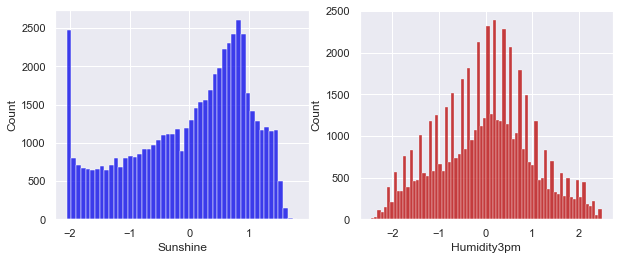

In [5]:
# histogrames per a la visualitzacio d'attrs

sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(top=0.85)
sl=sns.histplot(data=ws, x="Sunshine", color="#0000e9", ax=axs[0])
sw=sns.histplot(data=ws, x="Humidity3pm", color="#b80000", ax=axs[1])

#plt.savefig("hist_attGauss_A.png", dpi = 300, bbox_inches = 'tight')

Text(0, 0.5, 'Count')

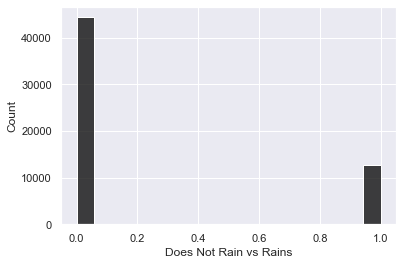

In [6]:
# historgrama del RainToday

p=sns.histplot(data=ws, x="RainToday", kde=False, color="black")

fig.suptitle("Players count of games with a certain game score",
             fontsize = 'x-large', fontweight = 'bold' )
p.set_xlabel("Does Not Rain vs Rains")
p.set_ylabel("Count")

#plt.savefig("hist_target_A.png", dpi = 300, bbox_inches = 'tight')

In [7]:
si = w['RainTomorrow'].value_counts()[1]
no = w['RainTomorrow'].value_counts()[0]
print("si:", si, "| no:", no)

si: 12606 | no: 44427


In [8]:
# inicialització de la base de dades

y_ws = ws["RainTomorrow"]
ws.drop(["RainTomorrow"], axis=1, inplace=True)
x_ws = ws

In [9]:
# pca amb var ret 95 

X_train_w, X_test_w, _ = split_df(x_ws, 0.5, 1)
y_train_w, y_test_w, _ = split_df(y_ws, 0.5, 1) 

pca_best = PCA(0.95)
x_train = pca_best.fit_transform(X_train_w)
x_test = pca_best.transform(X_test_w)

#informacio del millor pca
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")

Best PCA obtained with 47 components


In [10]:
# pca amb var ret 99

X_train_w, X_test_w, _ = split_df(x_ws, 0.5, 1)
y_train_w, y_test_w, _ = split_df(y_ws, 0.5, 1) 

pca_best = PCA(0.99)
x_train = pca_best.fit_transform(X_train_w)
x_test = pca_best.transform(X_test_w)

#informacio del millor pca
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")

Best PCA obtained with 65 components


In [11]:
# pca sense var ret

X_train_w, X_test_w, _ = split_df(x_ws, 0.5, 1)
y_train_w, y_test_w, _ = split_df(y_ws, 0.5, 1) 

pca_best = PCA()
x_train = pca_best.fit_transform(X_train_w)
x_test = pca_best.transform(X_test_w)

#informacio del millor pca
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")

Best PCA obtained with 77 components


### 3. Model Selection i 5. Metric Analysis

In [12]:
# funcio del fit del regressor logistic
def fit_lr(X, y, part=0.6):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001) 
    logireg.fit(x_t, y_t)
    probs = logireg.predict_proba(x_v)
    return logireg.score(x_v, y_v), probs, y_v

# funcio del fit del svm
def fit_svm(X, y, part = 0.6, k = 'linear', C = 10.0, g = 0.9):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    svc = svm.SVC(C=C, kernel=k, gamma=g, probability=True) # creem el regresor svm    
    svc.fit(x_t, y_t) 
    probs = svc.predict_proba(x_v) # s usa en el precision recall curve
    return svc.score(x_v, y_v), probs, y_v

# funcio del decision tree
def decision_tree_fit(X, y, part = 0.6):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    dt = tree.DecisionTreeClassifier()
    dt.fit(x_t, y_t)
    probs = dt.predict_proba(x_v)
    y_pred=dt.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred), probs, y_v

# funcio del random forest
def fit_rf(i,X, y, part = 0.6):
    
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(x_t,y_t)
    probs = clf.predict_proba(x_v)
    y_pred=clf.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred),probs,y_v

# funcio del KNN
def fit_KNN(X, y, part = 0.6, n =7):
    
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    clf = neighbors.KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_t,y_t)
    probs = clf.predict_proba(x_v)
    y_pred=clf.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred), probs, y_v

Proves sobre els diferents models

In [13]:
# knn
%time score, *_ = fit_KNN(x_ws, y_ws)
score

Wall time: 31.3 s


0.8441746296133953

In [14]:
# regressor logistic
%time score, *_ = fit_lr(x_ws, y_ws)
score

Wall time: 604 ms


0.8547821513105988

In [15]:
# random forest 100 arbres
%time score, *_ = fit_rf(10, x_ws, y_ws)
score

Wall time: 977 ms


0.8455334443762602

In [16]:
#arbre desicio
%time score, *_ = decision_tree_fit(x_ws, y_ws)
score

Wall time: 859 ms


0.7939861488559656

In [17]:
# proves sobre el svm utilitzant només les 10000 primeres dades sobre els atributs ['Sunshine','Humidity3pm'] 
# ja que son els que tenen més importancia
A = np.array(ws.loc[:,['Sunshine','Humidity3pm']])[:10000,:]
y_a = np.array(y_ws)[:10000]

In [18]:
# svm lineal 
%time score, *_ = fit_svm(A, y_a) #0.8290085035504515
score

Wall time: 5.45 s


0.82275

In [19]:
# svm amb totes les dades dels dos atributs més importants
# 0.8290085035504515  lineal

%time score, *_ = fit_svm(ws.loc[:,['Sunshine','Humidity3pm', 'Cloud3pm']], y_ws, part = 0.6) 
score

Wall time: 3min 9s


0.8285263434733059

In [20]:
# bagging knn

x_t, x_v, y_t, y_v = train_test_split(x_ws, y_ws, train_size=0.6)
clf = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=0).fit(x_t, y_t)

clf.score(x_v, y_v)

0.8442622950819673

In [21]:
'''# boosting adaptive (adaboost) 1000

b = time.time()
clf = AdaBoostClassifier(n_estimators=1000)
scores = cross_val_score(clf, x_ws, y_ws, cv=5)
e = time.time()

print("acc", scores.mean(),"temps: ", e-b)'''

'# boosting adaptive (adaboost) 1000\n\nb = time.time()\nclf = AdaBoostClassifier(n_estimators=1000)\nscores = cross_val_score(clf, x_ws, y_ws, cv=5)\ne = time.time()\n\nprint("acc", scores.mean(),"temps: ", e-b)'

In [23]:
'''# boosting adaptive (adaboost) 5000

b = time.time()
clf = AdaBoostClassifier(n_estimators=5000)
scores = cross_val_score(clf, x_ws, y_ws, cv=5)
e = time.time()

print("acc", scores.mean(),"temps: ", e-b)'''

'# boosting adaptive (adaboost) 5000\n\nb = time.time()\nclf = AdaBoostClassifier(n_estimators=5000)\nscores = cross_val_score(clf, x_ws, y_ws, cv=5)\ne = time.time()\n\nprint("acc", scores.mean(),"temps: ", e-b)'

In [24]:
# matriu de precisions dels diferents models
samples, models = 10, 5
acc_r = np.zeros((samples, models))

for i in range(samples):
    idxs = np.random.choice(ws.shape[0], int(ws.shape[0]/10), replace=False)
    acc_r[i][0], *_ = fit_KNN(np.array(x_ws)[idxs, :], np.array(y_ws)[idxs])
    acc_r[i][1], *_ = fit_rf(15, x_ws, y_ws)
    acc_r[i][2], *_ = decision_tree_fit(x_ws, y_ws)
    idxs = np.random.choice(ws.shape[0], int(ws.shape[0]/10), replace=False)
    acc_r[i][3], *_ = fit_svm(np.array(ws.loc[:, ['Sunshine', 'Humidity3pm']])[idxs, :], np.array(y_ws)[idxs]) #0.8290085035504515
    acc_r[i][4], *_ = fit_lr(x_ws, y_ws)

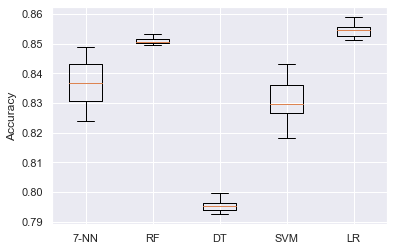

In [25]:
# accuracy boxplot
plt.boxplot(acc_r)   
ax = plt.gca()
ax.set_xticklabels(['7-NN', 'RF', 'DT', 'SVM', 'LR'])
plt.ylabel('Accuracy')
plt.savefig("boxplot_10iters", dpi=300, bbox_inches='tight')
plt.show()

### CROSSVAL

In [26]:
model = LogisticRegression(C=2, fit_intercept=True, penalty='l2', tol=0.001) 
scores_lr = cross_val_score(model, x_ws, y_ws, cv=10)
scores_lr

array([0.84782609, 0.8378331 , 0.84730014, 0.84131159, 0.84113624,
       0.82517973, 0.83780466, 0.87795897, 0.83657724, 0.87532877])

In [27]:
model = svm.SVC(kernel='linear', C=10, random_state=42)
idxs = np.random.choice(ws.shape[0], int(ws.shape[0]/10), replace=False)
scores_svc = cross_val_score(model, np.array(x_ws)[idxs,], np.array(y_ws)[idxs], cv=10)
scores_svc

array([0.84063047, 0.83887916, 0.83362522, 0.84035088, 0.84736842,
       0.82631579, 0.84561404, 0.84035088, 0.83157895, 0.87017544])

In [28]:
model = tree.DecisionTreeClassifier()
scores_dt = cross_val_score(model, x_ws, y_ws, cv=10)
scores_dt

array([0.78295933, 0.76262272, 0.76788219, 0.77853761, 0.77958969,
       0.74750132, 0.76503595, 0.82728389, 0.78204454, 0.78327196])

In [29]:
model = RandomForestClassifier(n_estimators=45)
scores_rf = cross_val_score(model, x_ws, y_ws, cv=10)
scores_rf

array([0.84414446, 0.84431978, 0.84028752, 0.84955287, 0.85253375,
       0.81378222, 0.8292127 , 0.88392074, 0.82903735, 0.86638611])

In [30]:
model = neighbors.KNeighborsClassifier(n_neighbors=7)
scores_knn = cross_val_score(model, x_ws, y_ws, cv=10)
scores_knn

array([0.82941795, 0.8164446 , 0.8266129 , 0.82500438, 0.8409609 ,
       0.74907943, 0.79992986, 0.86182711, 0.81763984, 0.85902157])

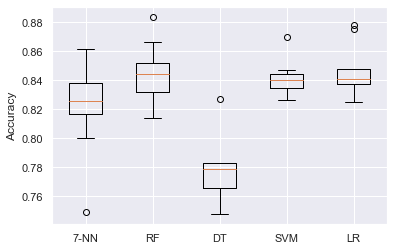

In [31]:
plt.boxplot([scores_knn, scores_rf, scores_dt, scores_svc, scores_lr])   
ax = plt.gca()
ax.set_xticklabels(['7-NN', 'RF', 'DT', 'SVM', 'LR'])
plt.ylabel('Accuracy')
plt.savefig("boxplot_cv.png", dpi=300, bbox_inches='tight')
plt.show()

### HYPERPARAMETER SEARCH

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x_ws, y_ws, test_size=0.5)

# Set the parameters by cross-validation
cs = np.logspace(-7, 2, 40)
tuned_parameters = [{"C": cs}]
scores = ["precision", "recall"]
meanss = []

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)

    means = clf.cv_results_["mean_test_score"]
    meanss.append(means)
    stds = clf.cv_results_["std_test_score"]

    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 3.455107294592218e-05}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     22165
           1       0.94      0.02      0.04      6352

    accuracy                           0.78     28517
   macro avg       0.86      0.51      0.46     28517
weighted avg       0.82      0.78      0.69     28517

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 7.017038286703837}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22165
           1       0.73      0.53      0.62      6352

    accu

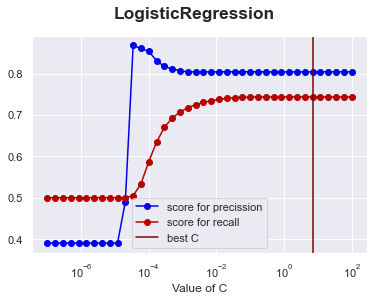

In [33]:
fig = plt.figure()

plt.suptitle("LogisticRegression", fontsize = 'x-large', fontweight = 'bold')
plt.plot(cs, meanss[0], "o-", label="score for precission", color="#0000e9")
plt.plot(cs, meanss[1], "o-", label="score for recall", color="#b80000")
plt.xscale("log")
plt.axis('tight')
plt.xlabel('Value of C')
plt.axvline(x=clf.best_params_['C'], color='#800000', label='best C')

plt.legend()
plt.savefig("hyper_lr.png", dpi = 300, bbox_inches = 'tight') 
plt.show()

In [34]:
idxs = np.random.choice(ws.shape[0], int(ws.shape[0]/10), replace=False)
X_train, X_test, y_train, y_test = train_test_split(np.array(ws.loc[:, ['Sunshine', 'Humidity3pm']])[idxs, :], np.array(y_ws)[idxs], test_size=0.5)

# Set the parameters by cross-validation
cs = np.logspace(-2.2, -0.2, 30)
tuned_parameters = [{"C": cs}]
scores = ["precision", "recall"]
meanss = []

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)

    means = clf.cv_results_["mean_test_score"]
    meanss.append(means)
    stds = clf.cv_results_["std_test_score"]

    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.008668242140342019}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      2228
           1       0.83      0.31      0.45       624

    accuracy                           0.84      2852
   macro avg       0.83      0.65      0.68      2852
weighted avg       0.83      0.84      0.80      2852

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.4592709387993501}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2228
           1       0.77      0.40      0.53       624

    accu

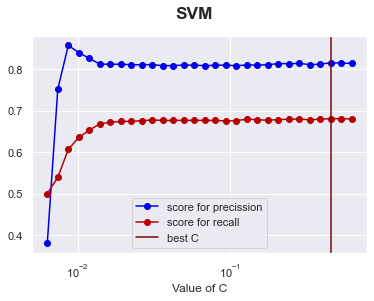

In [35]:
fig = plt.figure()

plt.suptitle("SVM", fontsize = 'x-large', fontweight = 'bold')
plt.plot(cs, meanss[0], "o-", label="score for precission", color="#0000e9")
plt.plot(cs, meanss[1], "o-", label="score for recall", color="#b80000")
plt.xscale("log")
plt.axis('tight')
plt.xlabel('Value of C')
plt.axvline(x=clf.best_params_['C'], color='#800000', label='best C')

plt.legend()
plt.savefig("hyper_svm.png", dpi = 300, bbox_inches = 'tight') 
plt.show()